#XGBoost預測介紹

由於金融市場的複雜性和動態性，股票預測是一項具有挑戰性的任務。 然而，隨著機器學習演算法的進步，我們可以利用這些技術做出預測。

XGBoost是一種流行的機器學習演算法，以其高效能和靈活性而聞名。 在處理結構化資料方面特別有效，並已廣泛用於包括金融在內的各個領域。

本代碼中，將納入技術指標，這些指標是基於歷史價格和數量數據的數學計算，以捕捉股市的模式和趨勢。 此外，將包括VIX指數，也稱為“恐懼指數”，它衡量市場波動。

XGBoost是一種整合學習演算法，它結合了多個弱模型（通常是決策樹）的預測，以創建一個強大的預測模型。 它使用梯度增強框架，其中對每個後續模型進行訓練，以糾正先前模型所犯的錯誤。

#XGBoost 的優點

**1）正規化**

XGBoost 在代價函數裡加入了正規項，用於控制模型的複雜度。 正規項裡包含了樹的葉子節點個數、每個葉節點上輸出的 score 的 L2 模的平方和。 從 Bias-variancetradeoff 角度來講，正規項降低了模型的 variance，使學習出來的模型更加簡單，防止過擬合，這也是XGBoost 優於傳統 GBDT 的一個特性。

**2）並行處理**

XGBoost 工具支援並行。 Boosting 不是一種串列的結構嗎?怎麼並行的？ 注意 XGBoost 的平行不是 tree 粒度的並行，XGBoost 也是一次迭代完才能進行下一次迭代的（第 t 次迭代的代價函數裡包含了前面 t-1 次迭代的預測值）。 XGBoost 的平行是在特徵粒度上的。 我們知道，決策樹的學習最耗時的一個步驟就是對特徵的值進行排序（因為要確定最佳分割點），XGBoost 在訓練之前，預先對資料進行了排序，然後保存為block結構，後面的 迭代中重複地使用這個結構，大幅減少計算量。 這個 block 結構也使得並行成為了可能，在進行節點的分裂時，需要計算每個特徵的增益，最終選增益最大的那個特徵去做分裂，那麼各個特徵的增益計算就可以開多線程進行。

**3）靈活性**

XGBoost 支援使用者自訂目標函數和評估函數，只要目標函數二階可導就行。

**4）缺失值的處理**

對於特徵的值有缺失的樣本，XGBoost 可以自動學習出它的分裂方向。

**5）剪枝**

XGBoost 先從頂到底建立所有可以建立的子樹，再從底到頂反向進行剪枝。

**6）內建交叉驗證**

XGBoost 允許在每一輪 Boosting 迭代中使用交叉驗證。 因此，可以輕鬆獲得最優Boosting 迭代次數。 而 GBM 使用網格搜索，只能偵測有限個值。

# XGBoost 的缺點或不足

雖然說 XGBoost 在 Kaggle 比賽中獲得了不錯的成績，但並不代表 XGBoost 是一個完美的演算法，它當然也有自己的缺點和不足之處:

**1）演算法參數過多**

調參複雜，需要對 XGBoost 原理十分清楚才能很好的使用 XGBoost。

**2）只適合處理結構化數據**

相對於深度學習演算法來說，XGBoost 演算法只適合處理結構化的特徵數據，而對於類似影像中的目標偵測等任務重的非結構化資料則沒有很好的處理能力。

**3）不適合處理超高維度特徵數據**

XGBoost 演算法對於中低維資料具有很好的處理速度和精度，但是對於例如大規模影像物體識別，或者是推薦演算法的某些場景中會出現的超高維特徵的資料就無能為力了，這時候我們 就需要藉助深度學習等演算法。

# 3.收集數據
使用`yfinance`庫直接從雅虎財經下載資料。 以銀行業為例，並下載摩根大通公司（JPM）的資料。

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed


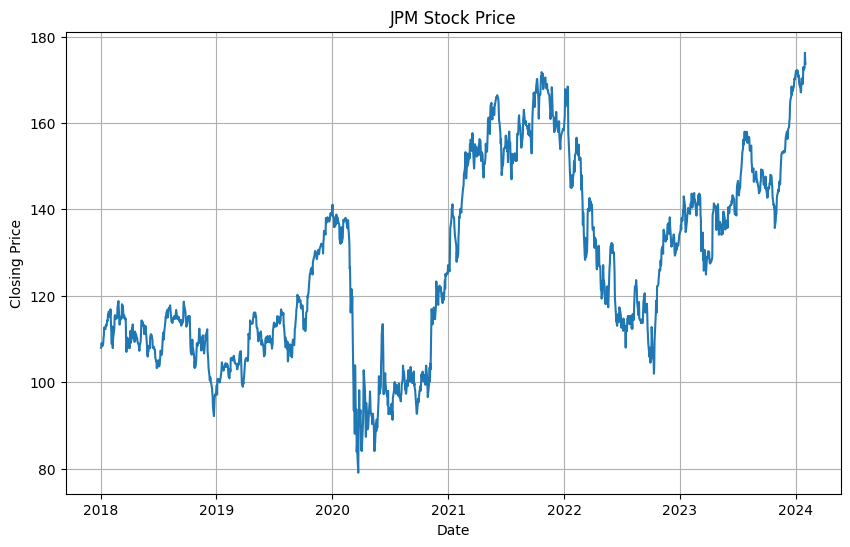

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt

# Downloading the data
ticker = "JPM"
start_date = "2018-01-01"
end_date = "2024-02-02"
data = yf.download(ticker, start=start_date, end=end_date)

# Plotting the closing price
plt.figure(figsize=(10, 6))
plt.plot(data["Close"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"{ticker} Stock Price")
plt.grid(True)

plt.show()

# 4.預處理數據
預處理資料是任何機器學習專案必不可少的一步。 涉及清理數據，處理缺失值，並將數據轉換為適合模型的格式。 計算簡單移動平均線（SMA）、指數移動平均線（EMA）、相對強度指數（RSI）、移動平均線收斂發散（MACD）和VIX指數，並作圖。

[*********************100%%**********************]  1 of 1 completed


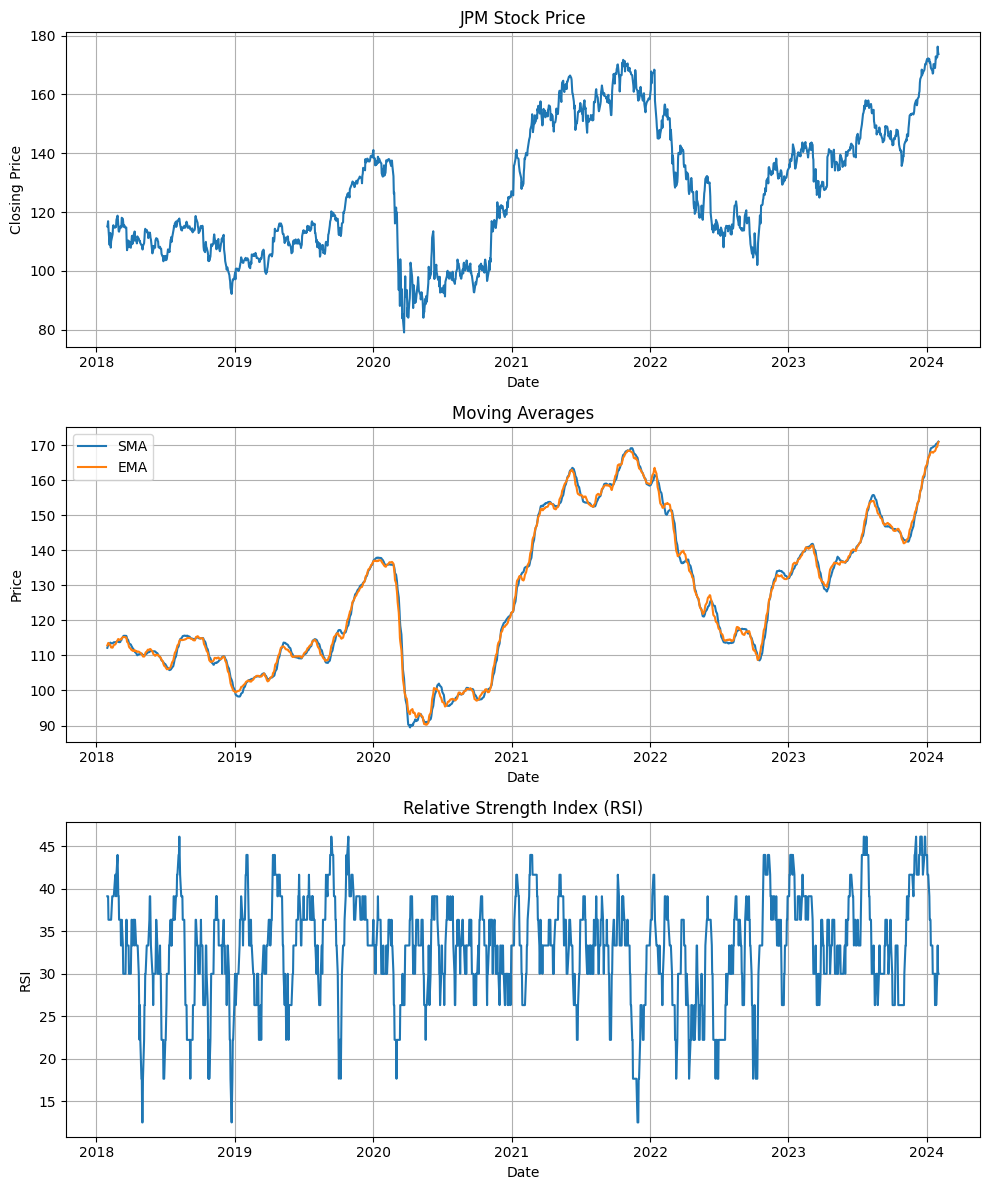

In [4]:
import pandas as pd

# Calculate technical indicators
data["SMA"] = data["Close"].rolling(window=20).mean()
data["EMA"] = data["Close"].ewm(span=20, adjust=False).mean()
data["RSI"] = 100 - (100 / (1 + (data["Close"].diff() > 0).rolling(window=14).mean()))
data["MACD"] = data["Close"].ewm(span=12, adjust=False).mean() - data["Close"].ewm(span=26, adjust=False).mean()
data["VIX"] = yf.download("^VIX", start=start_date, end=end_date)["Close"]

# Drop missing values
data.dropna(inplace=True)

# Plotting the technical indicators
plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
plt.plot(data["Close"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"{ticker} Stock Price")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(data["SMA"], label="SMA")
plt.plot(data["EMA"], label="EMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Moving Averages")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(data["RSI"])
plt.xlabel("Date")
plt.ylabel("RSI")
plt.title("Relative Strength Index (RSI)")
plt.grid(True)

plt.tight_layout()
plt.show()

# 5.特徵工程
特徵工程涉及從資料集中選擇和轉換相關特徵，以提高模型的性能，將使用技術指標和VIX指數作為功能。
建立了一個包含所選特徵的特徵矩陣X和包含收盤價的目標變數向量y。 然後，我們使用80-20拆分將資料拆分為訓練和測試集。

In [5]:
# Create feature matrix and target variable
features = ["SMA", "EMA", "RSI", "MACD" , "VIX"]

target = "Close"
X = data[features]
y = data[target]

# Splitting the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 6.建構XGBoost模型
要建立XGBoost模型，需要安裝`xgboost`函式庫並匯入必要的模組。 設定了XGBoost模型的參數，包括目標函數、最大深度、學習率、伽瑪和正規化λ。 然後，使用`xgb.train`函數訓練模型，並對訓練和測試集進行預測。 最後，計算均方根誤差（RMSE）來評估模型的表現。 RMSE越低，模型的預測就越好。

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Creating the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Setting the hyperparameters
params = {
    "objective": "reg:squarederror",
    "max_depth": 3,
    "learning_rate": 0.1,
    "gamma": 0,
    "reg_lambda": 1,
    "eval_metric": "rmse"
}

Train RMSE: 1.96
Test RMSE: 2.53


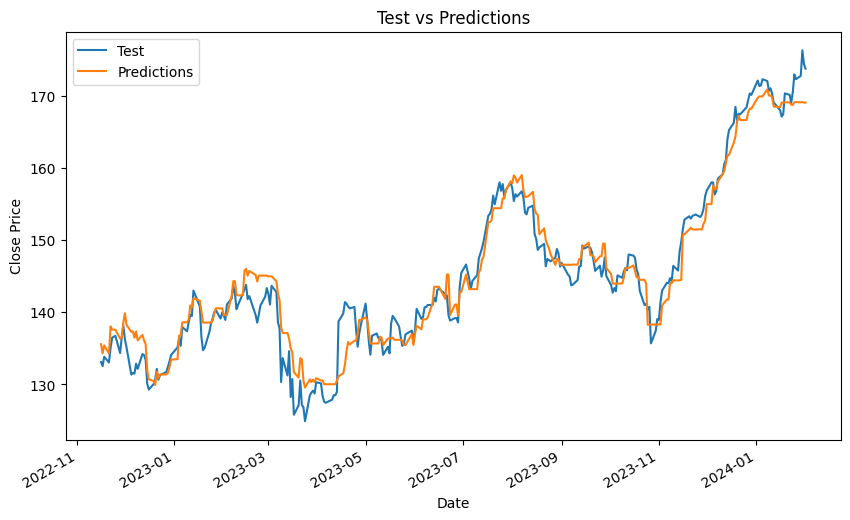

In [7]:
# Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred_train = model.predict(dtrain)
y_pred_test = model.predict(dtest)

# Calculating the root mean squared error
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"Train RMSE: {rmse_train:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")

# create a dataframe with the test and predictions data
df1 = pd.DataFrame({'Test': y_test, 'Predictions': y_pred_test})

# plot the test and predictions data as a line graph
df1.plot(kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Test vs Predictions')
plt.legend()
plt.show()

此模型的股票JPM輸出結果，RMSE還比較小，看起來蠻準的，但是換其他的票結果就不大理想。

# 7.後續工作
XGBoost為超參數調優提供了各種技術，例如網格搜尋和隨機搜尋。 後續可以探索其他技術指標和基本因素，以提高模型的預測能力。